In [1]:
import pandas as pd

In [3]:
df = pd.read_csv("../data/results.csv")
pd.set_option("display.max_columns", None)
df.head()

,Unnamed: 0,timestamp,arbitrageur_profit,arbitrageur_count,keeper_profit,keeper_count,liquidator_profit,liquidator_count,llamma_WETH_price,llamma_WETH_oracle_price,llamma_WETH_fees_x,llamma_WETH_fees_y,llamma_WETH_bal_x,llamma_WETH_bal_y,controller_WETH_system_health,controller_WETH_bad_debt,controller_WETH_num_loans,controller_WETH_debt,stableswap_crvUSD_TUSD_price,stableswap_crvUSD_TUSD_ma_price,stableswap_crvUSD_TUSD_lp_supply,stableswap_crvUSD_TUSD_virtual_price,stableswap_crvUSD_TUSD_TUSD_bal,stableswap_crvUSD_TUSD_crvUSD_bal,stableswap_crvUSD_USDP_price,stableswap_crvUSD_USDP_ma_price,stableswap_crvUSD_USDP_lp_supply,stableswap_crvUSD_USDP_virtual_price,stableswap_crvUSD_USDP_USDP_bal,stableswap_crvUSD_USDP_crvUSD_bal,stableswap_crvUSD_USDC_price,stableswap_crvUSD_USDC_ma_price,stableswap_crvUSD_USDC_lp_supply,stableswap_crvUSD_USDC_virtual_price,stableswap_crvUSD_USDC_USDC_bal,stableswap_crvUSD_USDC_crvUSD_bal,stableswap_crvUSD_USDT_price,stableswap_crvUSD_USDT_ma_price,stableswap_crvUSD_USDT_lp_supply,stableswap_crvUSD_USDT_virtual_price,stableswap_crvUSD_USDT_USDT_bal,stableswap_crvUSD_USDT_crvUSD_bal,pk_Curve.fi Factory Plain Pool: crvUSD/TUSD_debt,pk_Curve.fi Factory Plain Pool: crvUSD/TUSD_profit,pk_Curve.fi Factory Plain Pool: crvUSD/USDP_debt,pk_Curve.fi Factory Plain Pool: crvUSD/USDP_profit,pk_Curve.fi Factory Plain Pool: crvUSD/USDC_debt,pk_Curve.fi Factory Plain Pool: crvUSD/USDC_profit,pk_Curve.fi Factory Plain Pool: crvUSD/USDT_debt,pk_Curve.fi Factory Plain Pool: crvUSD/USDT_profit,aggregator_price,stablecoin_total_supply
0,0,2023-12-06 01:39:16,882.791983,1,0.0,0,0.0,0,2291230980906522297743,2292838064607570165760,1298573,0,173957619332331102149477,13581197221003783239133,3.477315e+17,7426865776185487294464000,245,22098749878229634001903803,997178462699128223,997178462699128223,4602598847318464060909400,1000000000000000000,1264873466526145414371197,3338894426962110535006828,994925052636487860,994925052636487860,4983836723625910875895581,1000000000000000000,1061013352791279189424468,3925270426883534549328084,994388433440009563,994080592987261800,34745774104237219907970604,1000000249931894737,7062779352975,27701857281533086153899539,994136837577183132,994136837577183132,31453878236842814267581273,1000000000000000000,6264825631313,25206863311104951236540147,0,0,0,0,0,0,0,0,994151975553486414,318422059505669552377897015
1,1,2023-12-06 02:39:16,900.068711,2,0.0,0,0.0,0,2291173016848158407275,2292838064607570165760,2516130,0,173957619332331102149477,13581197221003783239133,3.477097e+17,7426865776185487294464000,245,22099030820976638939124054,997416901905755665,997413172622485915,4602598847318464060909400,1000000497703907001,1310608449147751488231293,3293037901139141053378579,994416342089061987,994424284097964074,4983836723625910875895581,1000000459376025564,1015405524872912543081380,3971124659765565835572483,994388433440009563,994383617560784749,34745774104237219907970604,1000000249931894737,7062779352975,27701857281533086153899539,994136837577183132,994136837577183132,31453878236842814267581273,1000000000000000000,6264825631313,25206863311104951236540147,0,0,0,0,0,0,0,0,994283832622879768,318467913738551583664141414
2,2,2023-12-06 03:39:16,1182.437675,5,0.0,0,0.0,0,2294481004482486062160,2292838064607570165760,4962616,0,199900874107413096252224,13569949980146926108897,3.476949e+17,7426865776185487294464000,245,22099311767344611080710976,995828288278420623,995853018092046992,4602598847318464060909400,1000003114970706494,1070371242703773288117089,3534083131270600775160670,994020717365624004,994027018352766064,4983836723625910875895581,1000000779506977430,983632343266778437786394,4003084105809505057095473,994869257567648614,994780367198508823,34745774104237219907970604,1000000679478699764,7360152755894,27402894401691168548777915,994136837577183132,994136837577183132,31453878236842814267581273,1000000000000000000,6264825631313,25206863311104951236540147,0,0,0,0,0,0,0,0,994478139466695003,31876686166950206460154939

<Axes: >

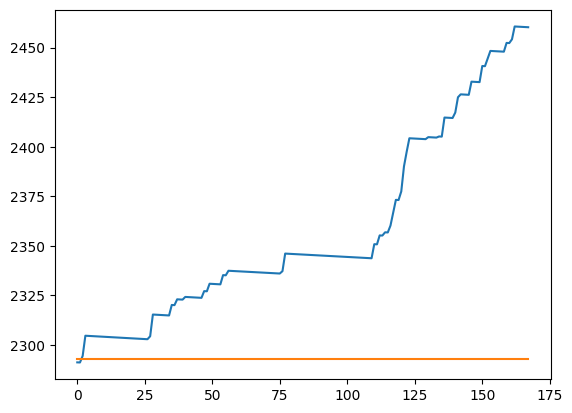

In [12]:
(df["llamma_WETH_price"].astype(float) / 1e18).plot()
(
    df["llamma_WETH_oracle_price"].astype(float) / 1e18
).plot()  # TODO llamma oracle price not changing